In [ ]:

# scikit-rf BJT Noise Model Compared to BJT Model in Fukui's Paper

In this example a BJT containing shot noise and thermal noise is simulated using NetworkNoiseCov objects attached to Network objects. The results are compared to analytic results from Fukui's paper below.  


* [1] H Fukui. - The noise performance of microwave transistors - IEEE Transactions on Electron Devices, (3):329-341, 1966


In [1]:
import fukui_functions as fukui
import numpy as npy
import skrf as rf
from skrf.constants import *
%matplotlib inline
from pylab import * 
rf.stylely()

Ic_ma = 20 #[mA]
beta0 = 100
rbb = 5 #[Ohms] Base Spreading Resistance
Cpi = 4e-12 #[F]
Cu = 1e-12 #[F] Feedback capacitance (not modeld by Fukui)
T0 = 290
k = K_BOLTZMANN
z0 = 50

frequency = rf.Frequency(start=1e6, stop=10e9, npoints=200, unit='Hz', sweep_type='log')

# dependant perameters
gm = Ic_ma/26.
re = 1/gm
rpi = beta0*re
gpi = 1/rpi
wT = 1/(Cpi*re + Cu*re)
scpi = 1j*frequency.w*Cpi
scu = 1j*frequency.w*Cu
sug_d = scu - gm

In [2]:
ovec = npy.ones(len(frequency))
zvec = npy.zeros(len(frequency))

# Series resistance containing thermal noise within the BJT
rbb_series_y = rf.network_array([[1/rbb*ovec,  -1/rbb*ovec],
                                 [-1/rbb*ovec,  1/rbb*ovec]])

# The next few networks are combined to create the BJT. 
gpi_shunt_a = rf.network_array([[ovec,     zvec],
                                [gpi*ovec, ovec]])

cpi_shunt_a = rf.network_array([[ovec,     zvec],
                                [scpi*ovec, ovec]])

cug_shfb_a = rf.network_array([[scu/sug_d,     ovec/sug_d],
                               [scu*gm/sug_d,   scu/sug_d]])

# This covariance matrix that accounts for the shot noise within the BJT
cov_bjt_y = 2*k*T0*gm*rf.network_array([[1/beta0*ovec,  zvec],
                                       [zvec,          ovec]])


a_bjt = npy.matmul(gpi_shunt_a, npy.matmul(cpi_shunt_a, cug_shfb_a))

# Create the series resisance network with attached covariance matrix representing thermal noise
nwrkRbb = rf.Network.from_y(rbb_series_y, frequency=frequency)
nwrkRbb.noise_source('passive')

# Create the BJT model and attach the covariance matrix representing shot noise
nwrkBjt = rf.Network.from_a(a_bjt, frequency=frequency)
shot_noise_cov_y = rf.NetworkNoiseCov(cov_bjt_y, form='y')
nwrkBjt.noise_source(shot_noise_cov_y)

# Combine the two networks together and calculate noise figure parameters
ntwkT = rf.cascade_2port(nwrkRbb, nwrkBjt)
model_nfmin_db = ntwkT.nfmin_db
model_nf_db = ntwkT.nf_db(z0)


In [3]:
# Calculate results for No-Parasitic case in Fukui's paper
fukui_nfmin = fukui.nfmin(gm, beta0, rbb, frequency.w, wT)
fukui_nf = fukui.nf(z0, gm, beta0, rbb, frequency.w, wT)


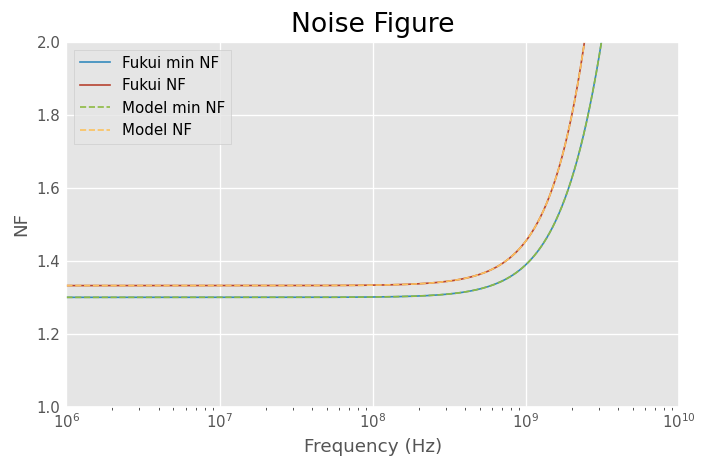

In [4]:
# Plot the results, the dashed lines represent the combined network from above and the solid lines are Fukui's results
figure(0)
ylabel('NF')
title('Noise Figure')
semilogx(frequency.f_scaled, rf.mf.mag_2_db10(fukui_nfmin), label=r'Fukui min NF')
semilogx(frequency.f_scaled, rf.mf.mag_2_db10(fukui_nf), label=r'Fukui NF')
semilogx(frequency.f_scaled, model_nfmin_db,'--' , label=r'Model min NF')
semilogx(frequency.f_scaled, model_nf_db,'--', label=r'Model NF')

ylim(1,2)

from skrf.plotting import func_on_all_figs as foaf

foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)

tight_layout()